In [1]:
import tensorflow as tf

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow_examples.models.pix2pix import pix2pix

# import tensorflow_datasets as tfds
# tfds.disable_progress_bar()

# from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
from __future__ import print_function
import os
import numpy as np
import skimage
from skimage import data, draw
from skimage import transform, util
import cv2
data_path = '../../Documents/ISIC2018-Segementation/'

image_rows = 420
image_cols = 580

In [7]:
def create_train_data():
    train_data_path = os.path.join(data_path, 'train/')
    images = sorted(os.listdir(train_data_path))
    total = len(images)
    imgs = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)

    i = 0
    print('-'*30)
    print('Creating train images...')
    print('-'*30)
    for image_name in images:
        # Read RGB image
        img = cv2.imread(os.path.join(train_data_path, image_name))
        # Convert to grayscale
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Rescale to image_rows x image_cols size
        resized_image = cv2.resize(gray_image, (image_cols, image_rows))
        resized_image = resized_image.reshape(resized_image.shape + (1,))
        img = np.array(resized_image)
        imgs[i] = img
        print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    np.save('imgs_train.npy', imgs)
    print('Saving to .npy files done.')

def create_train_masks_data():
    train_masks_data_path = os.path.join(data_path, 'train_masks/')
    images = sorted(os.listdir(train_masks_data_path))
    total = len(images)

    imgs = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)

    i = 0
    print('-'*30)
    print('Creating train masks images...')
    print('-'*30)
    for image_name in images:
#         print(image_name)
        # Read RGB image
        img = cv2.imread(os.path.join(train_masks_data_path, image_name))

        # Convert to grayscale
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Rescale to image_rows x image_cols size
        resized_image = cv2.resize(gray_image, (image_cols, image_rows))
        resized_image = resized_image.reshape(resized_image.shape + (1,))
        img = np.array(resized_image)

        img = np.array([img])

        imgs[i] = img

        print('Done: {0}/{1} images'.format(i, total))
        i += 1
    print('Loading done.')

    np.save('imgs_mask_train.npy', imgs)
    print('Saving to .npy files done.')

def load_train_data():
    imgs_train = np.load('../assets/imgs_train.npy')
    imgs_mask_train = np.load('../assets/imgs_mask_train.npy')
    return imgs_train, imgs_mask_train

# create_train_data()
# create_train_masks_data()

In [5]:
# from keras import backend as K
import tensorflow.keras.backend as K

img_rows = 224 
img_cols = 224

#img_rows = 420
#img_cols = 580

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def preprocess(imgs):
    imgs_p = np.ndarray((imgs.shape[0], img_rows, img_cols, 1), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        resized_image = cv2.resize(imgs[i], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
        imgs_p[i] = resized_image.reshape(resized_image.shape + (1,))
    return imgs_p

In [8]:
from sklearn.model_selection import train_test_split

train, mask = load_train_data()
train = preprocess(train)
mask = preprocess(mask)

train = train.astype('float32')
mean = np.mean(train)  # mean for data centering
std = np.std(train)  # std for data normalization

train -= mean
train /= std

mask = mask.astype('float32')
mask /= 255.  # scale masks to [0, 1]

X_train, X_test, y_train, y_test = train_test_split(train, mask, test_size=0.2, random_state=42)

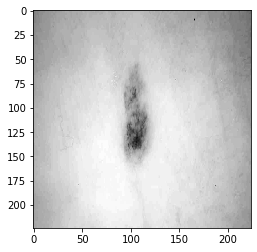

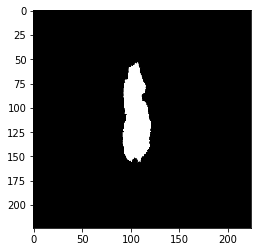

In [9]:
import random

img_index = random.randint(0, len(X_train))

plt.imshow(X_train[img_index].reshape(img_rows, img_cols), cmap='gray')
plt.show()

plt.imshow(y_train[img_index].reshape(img_rows, img_cols), cmap='gray')
plt.show()

In [10]:
import cv2
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout

def get_unet():
    concat_axis = 3
    
    inputs = Input(shape=[img_rows, img_cols, 1])
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Convolution2D(512, (3, 3), activation='relu', padding='same')(conv5)

#     up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    up6 = Concatenate(axis=concat_axis)([UpSampling2D(size=(2, 2))(conv5), conv4])
    conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Convolution2D(256, (3, 3), activation='relu', padding='same')(conv6)

#     up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    up7 = Concatenate(axis=concat_axis)([UpSampling2D(size=(2, 2))(conv6), conv3])
    conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Convolution2D(128, (3, 3), activation='relu', padding='same')(conv7)

#     up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    up8 = Concatenate(axis=concat_axis)([UpSampling2D(size=(2, 2))(conv7), conv2])
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Convolution2D(64, (3, 3), activation='relu', padding='same')(conv8)

#     up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    up9 = Concatenate(axis=concat_axis)([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Convolution2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Convolution2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

In [18]:
import cv2
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout

OUTPUT_CHANNELS = 3

# base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model MobileNet V2
mobilev2 = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               weights='imagenet')
x = mobilev2.layers[-2].output
predictions = Dense(7, activation='softmax')(x)
model = Model(inputs=mobilev2.input, outputs=predictions)

last_layers_training = -13 - 9 * 9

# for layer in model.layers[:last_layers_training]:
#     layer.trainable = False

filepath = "../assets/models/mobilenetv2/mobilenetv2_model_" + str(last_layers_training) + ".h5"
# checkpoint = ModelCheckpoint(filepath, 
#                              monitor='val_categorical_accuracy', 
#                              verbose=1, 
#                              save_best_only=True, mode='max')

# reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
#                                    verbose=1, mode='max', min_lr=0.00001)


# callbacks_list = [checkpoint, reduce_lr]

# history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
#                               class_weight=class_weights,
#                     validation_data=valid_batches,
#                     validation_steps=val_steps,
#                     epochs=20, verbose=1,
#                    callbacks=callbacks_list)

# Here the best epoch will be used.
model.load_weights(filepath)



# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

OSError: Unable to open file (unable to open file: name = '../assets/models/mobilenetv2/mobilenetv2_model_-94.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
model = get_unet()

model.compile(optimizer=Adam(lr=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy', 
                       tf.keras.metrics.MeanIoU(num_classes=2, name='MeanIoU')])

checkpoint = ModelCheckpoint(filepath='unet.hdf5', 
                             monitor='val_MeanIoU', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_MeanIoU', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)

callbacks_list = [checkpoint, reduce_lr]

history = model.fit(X_train,
                    y_train,
                    batch_size=8,
                    validation_data=(X_test, y_test),
                    validation_steps=8,
                    epochs=30, 
                    verbose=1,
                    callbacks=callbacks_list)

In [ ]:
# print('-'*30)
# print('Loading and preprocessing test data...')
# print('-'*30)
# imgs_test, imgs_id_test = load_test_data()
# imgs_test = load_test_data()
# imgs_test = preprocess(imgs_test)

# imgs_test = imgs_test.astype('float32')
# imgs_test -= mean
# imgs_test /= std
model = get_unet()
model.load_weights('unet.hdf5')
imgs_mask_test = model.predict(X_test)

In [ ]:
img_index = random.randint(0, len(X_test))

plt.imshow(imgs_mask_test[img_index].reshape(img_rows, img_cols), cmap='gray')
plt.show()

plt.imshow(y_test[img_index].reshape(img_rows, img_cols), cmap='gray')
plt.show()

# plt.imshow(imgs_mask_test)

In [ ]:
test_data_path = os.path.join(data_path, 'test/')
images = sorted(os.listdir(test_data_path))
total = len(images)
raw_imgs = []
imgs = np.ndarray((total, image_rows, image_cols, 1), dtype=np.uint8)

i = 0
print('-'*30)
print('Creating test images...')
print('-'*30)
for image_name in images:
    # Read RGB image
    img = cv2.imread(os.path.join(test_data_path, image_name))
    raw_imgs.append(img)
    # Convert to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Rescale to image_rows x image_cols size
    resized_image = cv2.resize(gray_image, (image_cols, image_rows))
    resized_image = resized_image.reshape(resized_image.shape + (1,))
    img = np.array(resized_image)
    imgs[i] = img
    print('Done: {0}/{1} images'.format(i, total))
    i += 1
print('Loading done.')

np.save('imgs_test.npy', imgs)
print('Saving to .npy files done.')

In [ ]:
imgs_test = np.load('imgs_test.npy')

test = preprocess(imgs_test)
test = test.astype('float32')
mean = np.mean(test)  # mean for data centering
std = np.std(test)  # std for data normalization

test -= mean
test /= std

In [ ]:
model = get_unet()
model.load_weights('unet.hdf5')
prediction = model.predict(test)

In [ ]:
img_index = random.randint(0, len(test))

plt.imshow(cv2.cvtColor(raw_imgs[img_index], cv2.COLOR_BGR2RGB))
plt.show()

# plt.imshow(test[img_index].reshape(img_rows, img_cols), cmap='gray')
# plt.show()

# plt.imshow(prediction[img_index].reshape(img_rows, img_cols), cmap='gray')
# plt.show()

img = cv2.resize(cv2.cvtColor(raw_imgs[img_index], cv2.COLOR_BGR2RGB), (240, 192))
mask = cv2.inRange(cv2.cvtColor(prediction[img_index], cv2.COLOR_GRAY2RGB),
                   (0.9, 0.9, 0.9),
                   (1, 1, 1))

# Create a blank 300x300 black image
red = np.zeros((192, 240, 3), np.uint8)
# Fill image with red color(set each pixel to red)
red[:] = (0, 50, 0)

plt.imshow(img + cv2.bitwise_and(red, red, mask=mask))

In [ ]:
## mask = (prediction[img_index].reshape(img_rows, img_cols) > 9e-1)
c = cv2.cvtColor(raw_imgs[img_index], cv2.COLOR_BGR2RGB)
img= cv2.resize(img, (240, 192))

print(np.shape(img))
kk = cv2.cvtColor(prediction[img_index], cv2.COLOR_GRAY2RGB)
print(np.shape(kk))
mask = cv2.inRange(kk, (0.9, 0.9, 0.9), (1, 1, 1))

plt.imshow(cv2.bitwise_and(img, img, mask=mask))
plt.show()
plt.imshow(img)
plt.show()

In [ ]:
kk

In [ ]:
plt.imshow((prediction[0].reshape(img_rows, img_cols) > 0.01) & (prediction[0].reshape(img_rows, img_cols) < 0.8))
plt.show()

plt.imshow(prediction[0].reshape(img_rows, img_cols), cmap='gray')
plt.show()